# FaUCI: Fairness Under Constrained Injection.
FaUCI (Fairness Under Constrained Injection) is an in-processing fairness algorithm that incorporates fairness constraints directly into the model training process through regularization.

This algorithm works by adding fairness-specific regularization terms to the loss function, which penalize the model when it produces unfair predictions. The model learns to balance between predictive accuracy and fairness during training.

The key idea is to use regularization to impose fairness constraints:
- The model is trained with a standard loss function (e.g., BCE loss by classification).
- A regularization term for fairness is added to the loss function to penalize unfair predictions
- The strength of the fairness constraint is controlled by a regularization weight parameter

FaUCI supports several fairness metrics as regularization targets:
- Statistical Parity Difference (SPD): Ensures similar prediction rates across demographic groups
- Disparate Impact (DI): Ensures that the ratio of positive prediction rates across groups is close to 1

The regularization weight controls the trade-off between fairness and accuracy:
- weight = 0: No fairness constraint (standard model)
- weight > 0: Increasing values impose stronger fairness constraints

In [1]:
import sys
import os

# Add the root directory of the project to PYTHONPATH
sys.path.append(os.path.abspath(os.path.join('..')))


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import openml

from fairlib import DataFrame
from fairlib.inprocessing import Fauci
from fairlib.metrics import statistical_parity_difference, disparate_impact

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## Loading and Preparing the Adult Dataset.
We will use the Adult dataset from OpenML, which contains demographic information and predicts whether an individual earns more than $50K per year.

In [3]:
adult_dataset = openml.datasets.get_dataset(179)
adult_X, _, _, _ = adult_dataset.get_data(dataset_format="dataframe")

adult_X.rename(columns={'class': 'income'}, inplace=True)

adult = DataFrame(adult_X)

adult.targets = 'income'
adult.sensitive = ['sex']

adult.drop(columns=["fnlwgt"], inplace=True)

label_maps = {}

for col in adult.columns:
    if adult[col].dtype == 'object' or adult[col].dtype == 'category':
        adult[col], uniques = pd.factorize(adult[col])
        label_maps[col] = uniques

print(f"Forma del dataset: {adult.shape}")
print(f"Colonna target: {adult.targets}")
print(f"Attributi sensibili: {adult.sensitive}")

adult.head()

Forma del dataset: (48842, 14)
Colonna target: {'income'}
Attributi sensibili: {'sex'}


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,income
0,0,0,0,13,0,0,0,0,0,0,0,0,0,0
1,1,1,0,13,1,1,1,0,0,1,0,1,0,0
2,0,2,1,9,2,2,0,0,0,1,0,0,0,0
3,1,2,2,7,1,2,1,1,0,1,0,0,0,0
4,2,2,0,13,1,3,2,1,1,1,0,0,1,0


## Exploratory Data Analysis.
We examine the distribution of income versus sex to understand potential inequalities in the dataset.

<Figure size 1000x600 with 0 Axes>

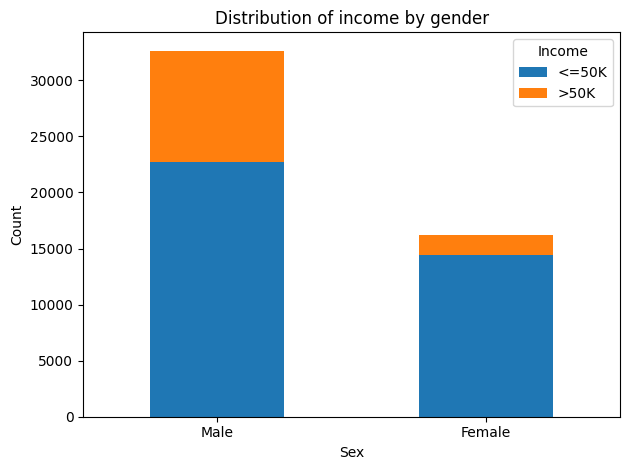

In [4]:
sex_labels = label_maps['sex'].tolist()
income_labels = label_maps['income'].tolist()

# Calculate the sex/income cross distribution.
counts = adult.groupby('sex')['income'].value_counts().unstack()

# Rename indexes and columns to make them readable
counts.index = [sex_labels[i] for i in counts.index]
counts.columns = [income_labels[i] for i in counts.columns]

# Plot
plt.figure(figsize=(10, 6))
counts.plot(kind='bar', stacked=True)
plt.title('Distribution of income by gender')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Income')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Preparing the Data for the Model.
We divide the dataset into training and test sets, and standardize the numerical characteristics.

In [5]:
X = adult.drop(columns=['income'])
y = adult['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
numeric_cols = ['age', 'education-num', 'capitalgain', 'capitalloss', 'hoursperweek']

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

sensitive_idx = X_train.columns.get_loc('sex')
sensitive_train = X_train.iloc[:, sensitive_idx].values
sensitive_test = X_test.iloc[:, sensitive_idx].values

print(f"Size of the training set: {X_train_tensor.shape}")
print(f"Size of the test set: {X_test_tensor.shape}")

Size of the training set: torch.Size([39073, 13])
Size of the test set: torch.Size([9769, 13])


## Implementing the Baseline Model.
Before implementing FaUCI, we train a baseline model to establish a baseline.

In [6]:
input_dim = X_train_tensor.shape[1]

class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.layer3(x))
        return x

base_model = BaseModel()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)

epochs = 100
batch_size = 128

for epoch in range(epochs):
    base_model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]

        outputs = base_model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        predictions = (outputs > 0.5).float()
        correct += (predictions == batch_y).sum().item()
        total += batch_y.size(0)

    if (epoch + 1) % 10 == 0:
        accuracy = 100 * correct / total
        avg_loss = epoch_loss / (len(X_train_tensor) // batch_size)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%\n")


Epoch [10/100], Loss: 0.3399, Accuracy: 84.29%

Epoch [20/100], Loss: 0.3267, Accuracy: 84.81%

Epoch [30/100], Loss: 0.3184, Accuracy: 85.20%

Epoch [40/100], Loss: 0.3133, Accuracy: 85.36%

Epoch [50/100], Loss: 0.3105, Accuracy: 85.46%

Epoch [60/100], Loss: 0.3085, Accuracy: 85.57%

Epoch [70/100], Loss: 0.3069, Accuracy: 85.65%

Epoch [80/100], Loss: 0.3056, Accuracy: 85.74%

Epoch [90/100], Loss: 0.3046, Accuracy: 85.81%

Epoch [100/100], Loss: 0.3036, Accuracy: 85.78%



## Evaluation of the Base Model.
We evaluate the performance of the base model in terms of both accuracy and fairness.

In [7]:
SENSITIVE_COL_NAME="sex"
base_model.eval()
with torch.no_grad():
    y_pred_base = base_model(X_test_tensor)
    y_pred_base_binary = (y_pred_base > 0.5).float()

    X_test_baseline = X_test_tensor.detach().cpu().numpy()
    y_pred_baseline = y_pred_base_binary.detach().cpu().numpy()

    baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
    print(f"Baseline model accuracy: {baseline_accuracy:.4f}")

    baseline_spd = statistical_parity_difference(y_pred_baseline, X_test[SENSITIVE_COL_NAME])
    baseline_di = disparate_impact(y_pred_baseline, X_test[SENSITIVE_COL_NAME])

    print(f"Statistical Parity Difference (SPD): {baseline_spd}")
    print(f"Disparate Impact (DI): {baseline_di}")

Baseline model accuracy: 0.8448
Statistical Parity Difference (SPD): [[-0.16785267  0.16785267]
 [ 0.16785267 -0.16785267]]
Disparate Impact (DI): [[1.2202982  0.29493248]
 [0.81947183 3.39060655]]


## Implementation of FaUCI.
We now implement FaUCI with different regularization weights to explore the trade-off between accuracy and fairness.

In [8]:
reg_weights = [0.0, 0.1, 0.3, 0.5, 0.6, 0.8]

accuracies = {}
spd_values = {}
di_values = {}

for weight in reg_weights:
    print(f" FaUCI training with regularization weight: {weight}")

    model = BaseModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    fauci_model = Fauci(
        torchModel=model,
        optimizer=optimizer,
        loss=nn.BCELoss(),
        fairness_regularization="spd",  # Statistical Parity Difference
        regularization_weight=weight
    )

    train_data = DataFrame(X_train_scaled)
    train_data['income'] = y_train.values
    train_data.targets = 'income'
    train_data.sensitive = ['sex']

    fauci_model.fit(train_data, epochs=epochs, batch_size=batch_size, verbose=False)

    base_model.eval()
    with torch.no_grad():
        y_pred_base = fauci_model.predict(X_test_tensor)
        y_pred_base_binary = (y_pred_base > 0.5).float()

        y_pred_baseline = y_pred_base_binary.detach().cpu().numpy()

        baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
        print(f"Baseline model accuracy: {baseline_accuracy:.4f}")

        baseline_spd = statistical_parity_difference(y_pred_baseline, X_test[SENSITIVE_COL_NAME])
        baseline_di = disparate_impact(y_pred_baseline, X_test[SENSITIVE_COL_NAME])

        print(f"Statistical Parity Difference (SPD): {baseline_spd}")
        print(f"Disparate Impact (DI): {baseline_di}")

 FaUCI training with regularization weight: 0.0
Baseline model accuracy: 0.8464
Statistical Parity Difference (SPD): [[-0.18350284  0.18350284]
 [ 0.18350284 -0.18350284]]
Disparate Impact (DI): [[1.2542125  0.34027801]
 [0.79731306 2.93877349]]
 FaUCI training with regularization weight: 0.1
Baseline model accuracy: 0.8456
Statistical Parity Difference (SPD): [[-0.15141224  0.15141224]
 [ 0.15141224 -0.15141224]]
Disparate Impact (DI): [[1.19616063 0.336264  ]
 [0.83600812 2.97385387]]
 FaUCI training with regularization weight: 0.3
Baseline model accuracy: 0.8450
Statistical Parity Difference (SPD): [[-0.15919861  0.15919861]
 [ 0.15919861 -0.15919861]]
Disparate Impact (DI): [[1.2087725  0.32956049]
 [0.82728553 3.03434429]]
 FaUCI training with regularization weight: 0.5
Baseline model accuracy: 0.8469
Statistical Parity Difference (SPD): [[-0.15082012  0.15082012]
 [ 0.15082012 -0.15082012]]
Disparate Impact (DI): [[1.19477579 0.33168794]
 [0.83697712 3.01488198]]
 FaUCI training 